<a id='top'></a>
<h1 align="center">MCMC Tutorial Part 3</h1>

<br>

**Authors:** John Letey, Mingxuan Zhang, and Tony E Wong

### Table of Contents

- [Packages](#packages)
- [Data Cleaning](#data-cleaning)
- [Log-Likelihood Function](#log-likelihood)
- [Log-Prior Distribution](#log-prior)
- [Log-Posterior Distribution](#log-posterior)
- [Adaptive Metropolis-Hastings Algorithm](#amha)
- [Gelman-Rubin Diagnostic](#gr-diagnostic)
- [Auto Correlation Function](#ac-function)
- [Running the Algorithm](#running-algo)
- [Diagnostic Plots](#diag-plots)

<a id='packages'></a>
***
<h2 align="center">Packages</h2>
[Back to top](#top)

<br>

These are all of the packages we are going to be using:

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")
%load_ext blackcellmagic

***

<a id='data-cleaning'></a>
***
<h2 align="center">Data Cleaning</h2>
[Back to top](#top)

<br>

For this tutorial, the hourly sea level data set we are going to analyze is from [The University of Hawaii Sea-Level Center](https://uhslc.soest.hawaii.edu/data/?rq), and we will try to fit the annual maxima sea level for Galveston by using a GEV distribution and what we have learned in the previous tutorial chapters!

Before we start our MCMC algorithm, we have to do some Data Cleaning, since it is normal to have missing values for these kind of data sets, and usually people will use fill-in values to do the job of filling the missing values in. Therefore, we have to find the fill-in value, and drop all of them.

First, Let's take a look at the raw data set.

In [2]:
dfSL = pd.read_csv("../data/Galveston.csv", header=None)
dfSL.rename(
    columns={0: "year", 1: "month", 2: "day", 3: "hour", 4: "sealevel"}, inplace=True
)
dfSL.head()

,year,month,day,hour,sealevel
0,1904,1,1,6,961
1,1904,1,1,7,992
2,1904,1,1,8,961
3,1904,1,1,9,900
4,1904,1,1,10,809


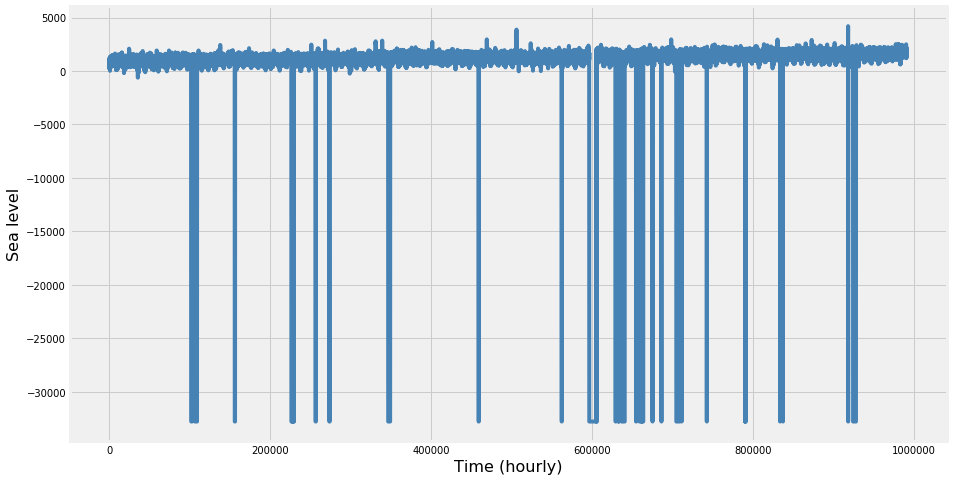

In [3]:
plt.figure(figsize=(14, 8))
plt.plot(dfSL["sealevel"], color="steelblue")
plt.xlabel("Time (hourly)", fontsize=16)
plt.ylabel("Sea level", fontsize=16)
plt.axis(alpha=0.5)
plt.show()

<br>

The long vertical lines in the above graph are telling us there are some missing values, so let's find them. Since the fill-in value is some negative small constant (which you can tell from the graph above) it is easy to find them. The following code will do the job:

In [4]:
fill_in = dfSL.loc[dfSL["sealevel"] < -5000].median()[4]
print("The fill in value is {0}".format(fill_in))

The fill in value is -32767.0


<br>

Now, since we knew what is the fill-in value, we can drop all of them, and take a look at the data set again! (Note that the unit for the sea level is millimeters):

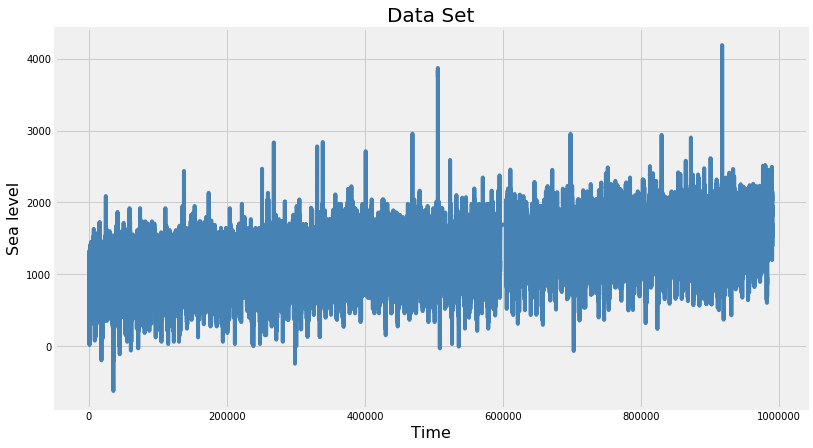

In [5]:
dfSL["sealevel"].replace(fill_in, np.nan, inplace=True)
dfSL.dropna(inplace=True)

plt.figure(figsize=(12, 7))
plt.plot(dfSL["sealevel"], color="steelblue")
plt.title("Data Set", fontsize=20)
plt.xlabel("Time", fontsize=16)
plt.ylabel("Sea level", fontsize=16)
plt.axis(alpha=0.5)
plt.show()

<br>

Before we extract the annual maxima sea level for each year, we have to find the years which are good enough to use. Why? Because if one particular year has a lot of missing data, the annual maximum sea level for that year is inaccurate! The threshold is we will only use the years where the number of missing values are less or equal to **10%** of that year.

In [6]:
n_hours = 365 * 24
sl_year = {}

for index, row in dfSL.iterrows():
    year = row["year"]
    sl = row["sealevel"]
    if year in sl_year:
        sl_year[year].append(sl)
    else:
        sl_year[year] = []
        sl_year[year].append(sl)

max_sl = {}

for year, sealevel in sl_year.items():
    if len(sealevel) / n_hours >= 0.9:
        max_sl[year] = max(np.array(sealevel) - np.mean(sealevel))

<br>

Now, we are ready to go! Let's take a look at the histogram of the annual maximum sea level at Galveston!

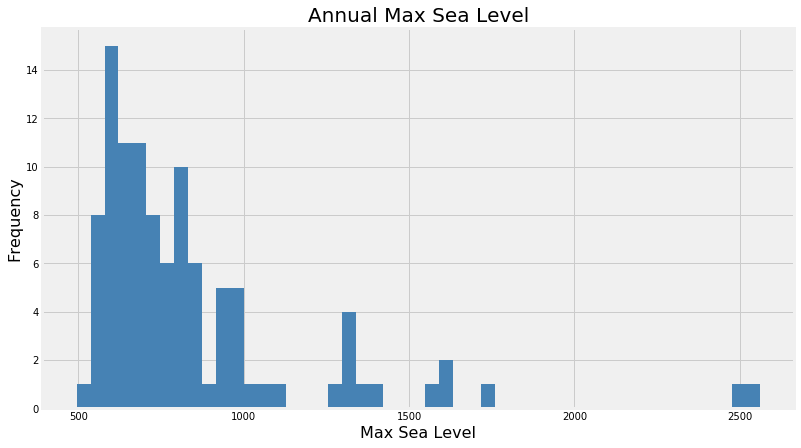

There are 103 years we can use


In [7]:
data_meas = list(max_sl.values())

plt.figure(figsize=(12, 7))
plt.hist(x=data_meas, bins=np.linspace(min(data_meas), max(data_meas)), color="steelblue")
plt.title("Annual Max Sea Level", fontsize=20)
plt.xlabel("Max Sea Level", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.axis(alpha=0.5)
plt.show()

print("There are {0} years we can use".format(len(data_meas)))

<a id='log-likelihood'></a>
***
<h2 align="center">Log-Likelihood Function</h2>
[Back to top](#top)

<br>

The same log-likelihood function from chapter 2:

In [8]:
def likelihood(parameters, data_meas=data_meas):
    u, s, shape = parameters
    prod = 1
    for i in range(len(data_meas)):
        pdf = stats.genextreme.pdf(x=data_meas[i], loc=u, scale=s, c=shape)
        if pdf == 0:
            return -np.inf
        prod += np.log(pdf)
    return prod

***

<a id='log-prior'></a>
***
<h2 align="center">Log-Prior Distribution</h2>
[Back to top](#top)

<br>

Again the same log-prior distribution from chapter 2!

In [9]:
def prior(parameters):
    u, s, shape = parameters
    u_pdf = stats.norm.pdf(x=u, loc=0, scale=1000)
    shape_pdf = stats.norm.pdf(x=shape, loc=0, scale=1000)
    if s >= 10000 or s <= 0 or u_pdf == 0 or shape_pdf == 0:
        return -np.inf
    else:
        return np.log(u_pdf) + np.log(1 / 10000) + np.log(shape_pdf)

***

<a id='log-posterior'></a>
***
<h2 align="center">Log-Posterior Distribution</h2>
[Back to top](#top)

In [10]:
def logpost(parameters, data_meas=data_meas):
    pi = prior(parameters)
    if pi == -np.inf:
        return -np.inf
    L = likelihood(parameters, data_meas)
    return L + pi

***

<a id='amha'></a>
***
<h2 align="center">Adaptive Metropolis-Hastings Algorithm</h2>
[Back to top](#top)

<br>

Let us set up some helper functions and the parameters for adaptive MCMC algorithm:

In [11]:
def runner(
    m, n_iter, data_meas=data_meas, logpost=logpost, t=1000, stepsize=[10, 2, 0.01]
):
    loc_est = np.median(data_meas)
    scale_est = (np.percentile(data_meas, 75) - np.percentile(data_meas, 25)) / 2
    shape_est = 0
    gevfit = stats.genextreme.fit(data_meas, loc=loc_est, scale=scale_est)

    if likelihood([gevfit[1], gevfit[2], gevfit[0]], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = gevfit[1], gevfit[2], gevfit[0]

    elif likelihood([loc_est, scale_est, -0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, -0.1

    elif likelihood([loc_est, scale_est, 0.1], data_meas) > -np.inf:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0.1

    else:
        loc_est, scale_est, shape_est = loc_est, scale_est, 0

    problems = []
    for i in range(m):
        ui = np.random.randint(low=loc_est, high=loc_est + 100)
        si = np.random.randint(low=scale_est, high=scale_est + 100)
        shapei = shape_est
        theta = [ui, si, shapei]
        state = State(theta, logpost(theta, data_meas))
        problems.append(ProblemMCMC(state, logpost, stepsize, data_meas, t))
    ar, mcmc_chains, ls = [], [], []
    for i in range(m):
        u, s, shape, l, r = mcmc(problems[i], n_iter)
        mcmc_chains.append([u, s, shape])
        ar.append(r)
        ls.append(l)
    return mcmc_chains, ar, ls

In [12]:
def plot_sequences(mcmc_chains):
    for i in range(len(mcmc_chains)):
        fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(16, 6))
        ax[0].plot(mcmc_chains[i][0], color="steelblue")
        ax[0].set_xlabel("Iteration")
        ax[0].set_ylabel("$\mu$ Trace")
        ax[0].set_title("Sequence {}".format(i + 1), fontsize=15)
        ax[0].grid(alpha=0.25)
        ax[1].plot(mcmc_chains[i][1], color="steelblue")
        ax[1].set_xlabel("Iteration")
        ax[1].set_ylabel("$\sigma$ Trace")
        ax[1].set_title("Sequence {}".format(i + 1), fontsize=15)
        ax[1].grid(alpha=0.25)
        ax[2].plot(mcmc_chains[i][2], color="steelblue")
        ax[2].set_xlabel("Iteration")
        ax[2].set_ylabel("shape parameter Trace")
        ax[2].set_title("Sequence {}".format(i + 1), fontsize=15)
        ax[2].grid(alpha=0.25)

In [13]:
eps = 0.0001
d = 3
I_d = np.identity(d)
S_d = (2.4) ** 2 / d


def update_cov(X):
    cov = np.cov(X)
    return S_d * cov + I_d * eps * S_d


class State:
    def __init__(self, state, value):
        self.state = state
        self.value = value


class ProblemMCMC:
    def __init__(self, initial, logposterior, stepsize, data_meas, t):
        self.current = initial
        self.logpost = logposterior
        self.stepsize = stepsize
        self.data_meas = data_meas
        self.t = t

    def random_move(self, t, X):
        if t <= self.t:
            next_move = stats.multivariate_normal.rvs(self.current.state, self.stepsize)
        else:
            cov = update_cov(X)
            next_move = stats.multivariate_normal.rvs(self.current.state, cov)
        return next_move, self.logpost(next_move, self.data_meas)

In [14]:
def mcmc(problem, n_iter):
    u = [problem.current.state[0]]
    s = [problem.current.state[1]]
    shape = [problem.current.state[2]]
    lpost = [problem.current.value]
    n_accept = 0
    S = 0
    np.seterr(over="ignore")
    for t in range(n_iter):
        S += 1
        nextMove, nextValue = problem.random_move(t, [u, s, shape])
        delta_obj = np.exp(nextValue - lpost[-1])
        if delta_obj > 1:
            n_accept += 1
            u.append(nextMove[0])
            s.append(nextMove[1])
            shape.append(nextMove[2])
            lpost.append(nextValue)
            problem.current.state = nextMove
            problem.current.value = nextValue
        else:
            p_accept = delta_obj
            accept = np.random.choice([True, False], p=[p_accept, 1 - p_accept])
            if accept:
                n_accept += 1
                u.append(nextMove[0])
                s.append(nextMove[1])
                shape.append(nextMove[2])
                lpost.append(nextValue)
                problem.current.state = nextMove
                problem.current.value = nextValue
            else:
                u.append(u[-1])
                s.append(s[-1])
                shape.append(shape[-1])
                lpost.append(lpost[-1])

    return (u, s, shape, lpost, n_accept / S)

<a id='gr-diagnostic'></a>
***
<h2 align="center">Gelman-Rubin Diagnostic</h2>
[Back to top](#top)

In [15]:
def GR_diag(parameter, interval=100, start=100, plot=False):
    end = len(parameter[0])
    m = len(parameter)
    GR_result = []
    x_range = []
    for n in range(start, end, interval):
        x_range.append(n)
        sequences = []
        for i in range(m):
            sequences.append(parameter[i][:n])
        GR_result.append(psrf(sequences))
    burnin = 0
    for i in range(len(GR_result)):
        if max(GR_result[i:]) < 1.1:
            burnin = i + 1
            break
    if plot:
        plt.figure(figsize=(14, 6))
        plt.scatter(x=x_range, y=GR_result, label="GR diagnostic")
        plt.vlines(
            burnin * interval,
            ymin=1,
            ymax=max(GR_result),
            label="burn in={0}".format(burnin * interval),
        )
        plt.xlabel("Iteration", fontsize=14)
        plt.ylabel("Potential Scale Reduction Fator", fontsize=14)
        plt.title("Gelman & Rubin Diagnostic", fontsize=14)
        plt.legend(loc="best")
        plt.show()
    return GR_result, burnin * interval


def psrf(sequences):
    u = [np.mean(sequence) for sequence in sequences]
    s = [np.var(sequence, ddof=1) for sequence in sequences]
    m = len(sequences)
    n = len(sequences[0])
    U = np.mean(u)
    B, W = 0, 0
    for i in range(m):
        B += (u[i] - U) ** 2
        W += s[i]
    B = (B * n) / (m - 1)
    W = W / m
    Var = (1 - (1 / n)) * W + (B / n)
    return np.sqrt(Var / W)

***

<a id='ac-function'></a>
***
<h2 align="center">Auto Correlation Function</h2>
[Back to top](#top)

In [16]:
def ACF(X, end=200, interval=1, plot=False):
    N = len(X)
    acf = []
    x_range = []
    for a in range(0, end, interval):
        x_range.append(a)
        acf.append(np.corrcoef(X[a:], X[:N-a])[0][1])
        
    lag = 0
    for i in range(len(acf)):
        if acf[i] <= 0.05:
            lag = i
            break
    if plot:
        plt.figure(figsize=(8, 6))
        plt.stem(x_range, acf, label='ACF')
        plt.vlines(x=lag, ymin=0, ymax=1, label='lag = {0}'.format(lag))
        plt.xlabel('Lag', fontsize=12)
        plt.ylabel('ACF', fontsize=12)
        plt.legend(loc='best')
        plt.show()
    return lag

***

<a id='running-algo'></a>
***
<h2 align="center">Running the Algorithm</h2>
[Back to top](#top)

<br>

Finally, we can start the MCMC algorithm, We will generate three sequences each with 10000 iterations!

In [17]:
t=1000
mcmc_chains, ar, ls = runner(m=3, n_iter=10000, t=t)

<br>

### Process our sequences!

Let's do the GR diagnositc and thinning for our three sequences, and get the final pool of parameters which is ready to analysis and the the parameter sets which has the max log-!posterior score

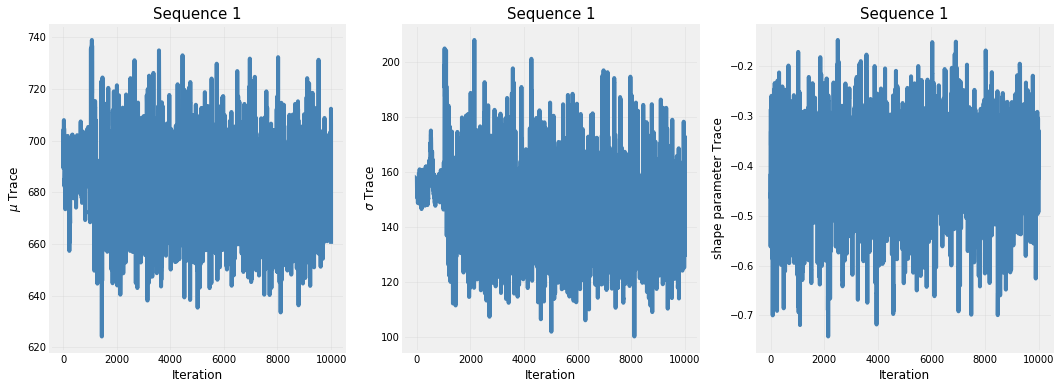

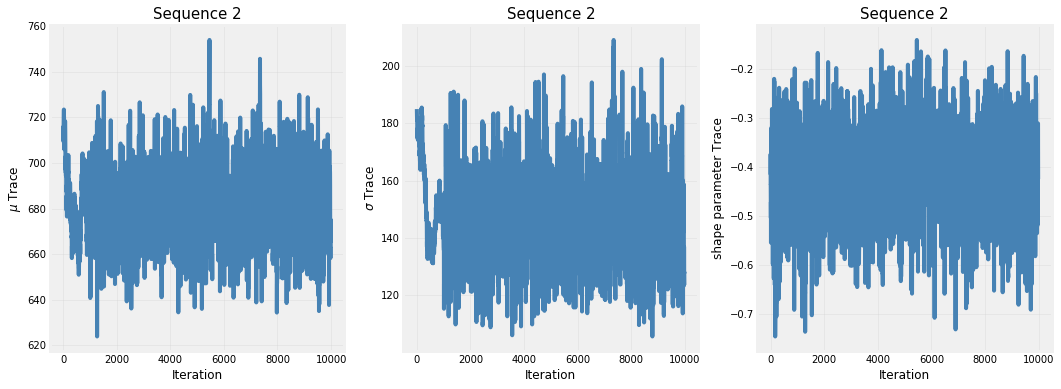

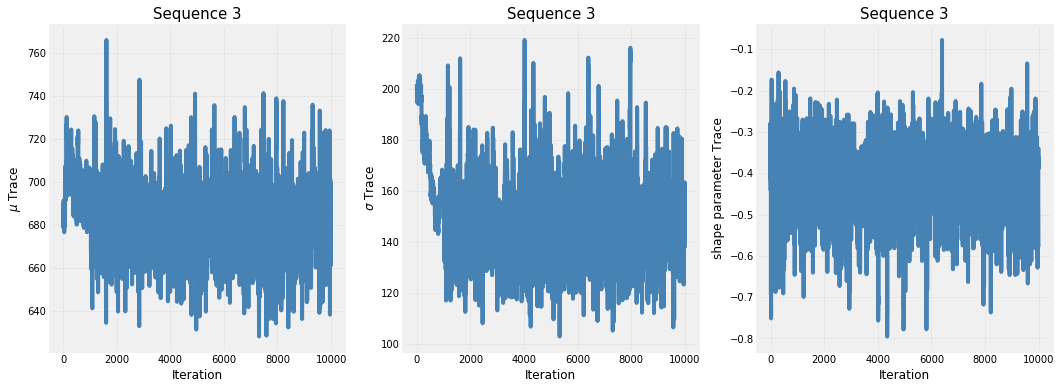

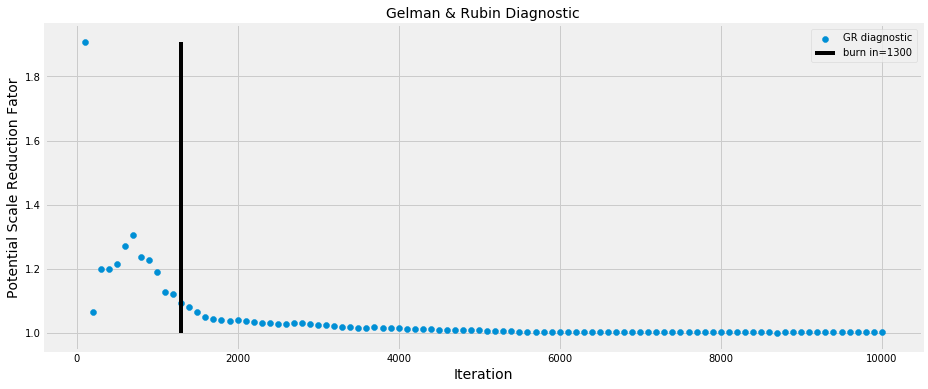

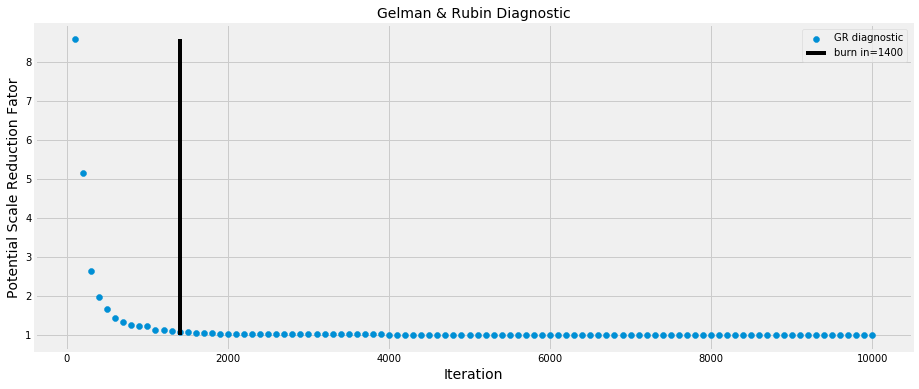

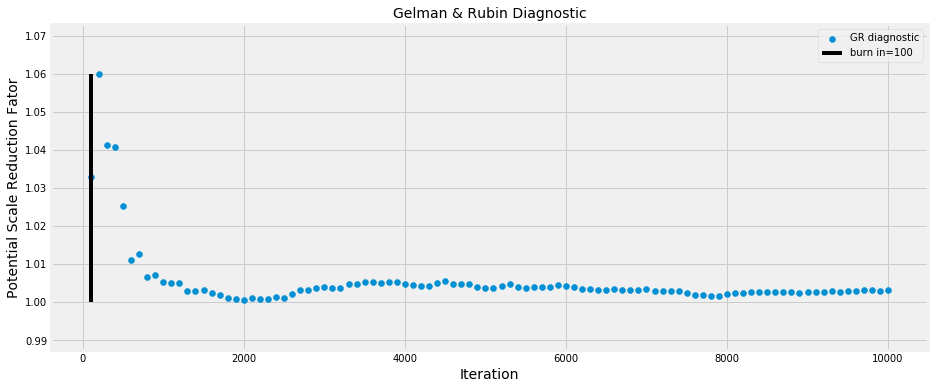

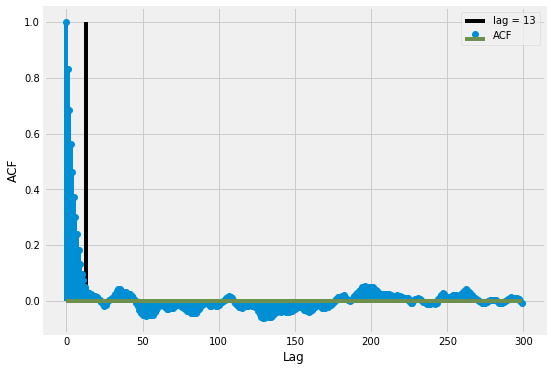

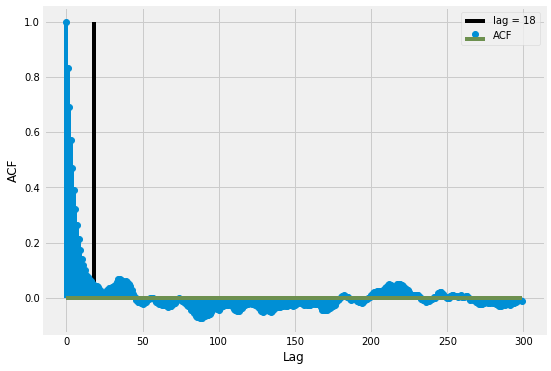

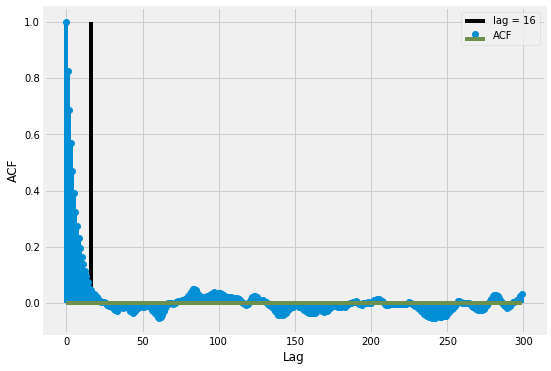

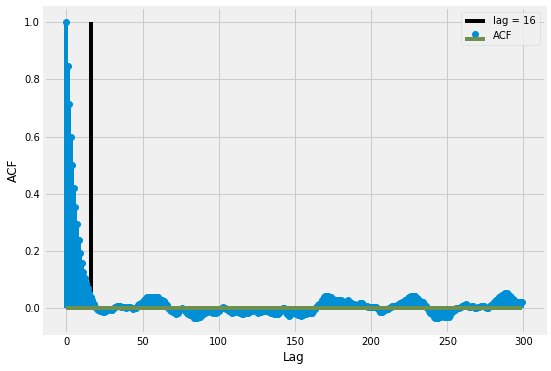

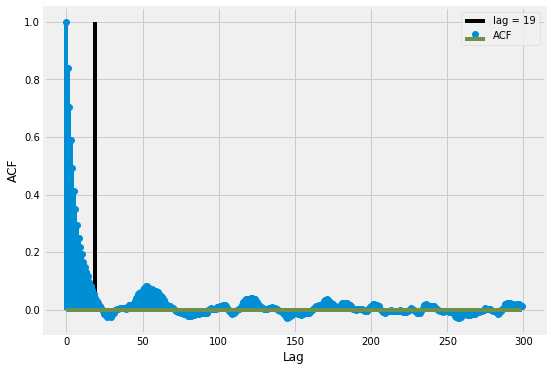

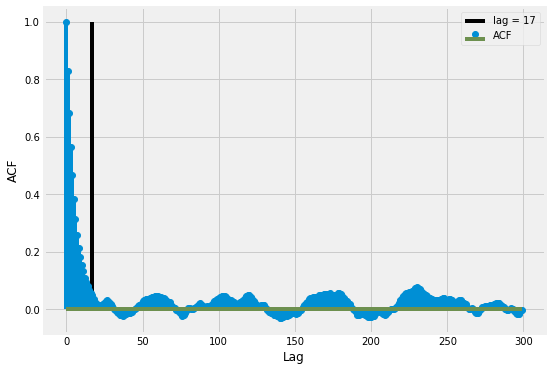

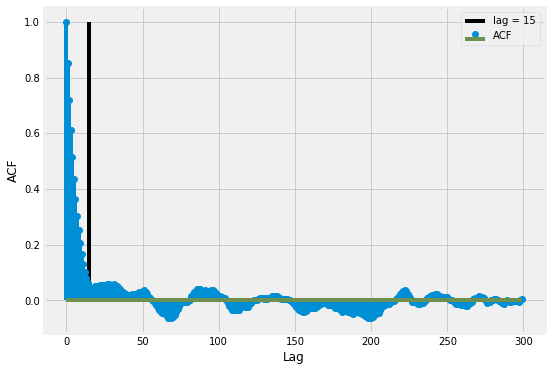

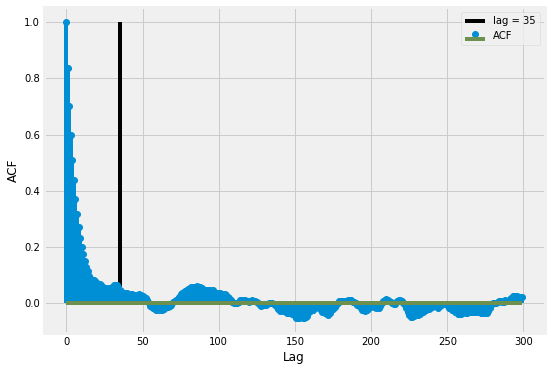

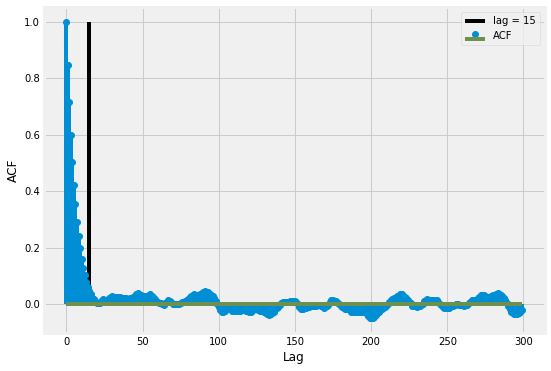

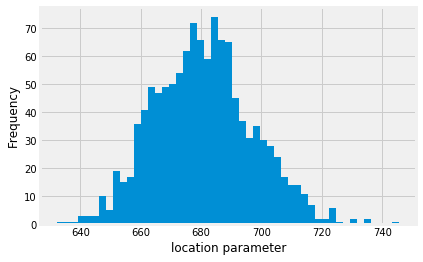

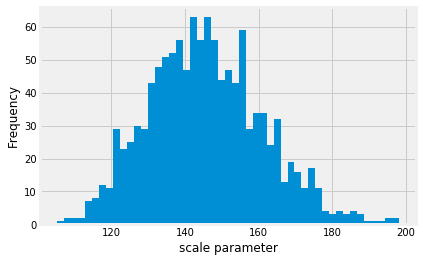

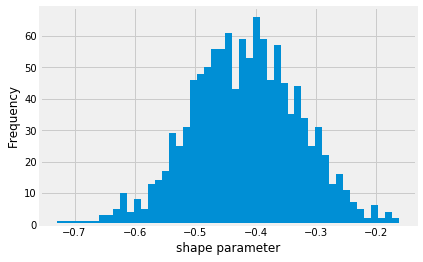

In [18]:
plot_sequences(mcmc_chains)

u_raw, s_raw, shape_raw =[], [], []

for mcmc_chain in mcmc_chains:
    u_raw.append(mcmc_chain[0])
    s_raw.append(mcmc_chain[1])
    shape_raw.append(mcmc_chain[2])
    
GR_u, burnin1 = GR_diag(u_raw, plot=True)
GR_s, burnin2 = GR_diag(s_raw, plot=True)
GR_shape, burnin3 = GR_diag(shape_raw, plot=True)
burnin = max([burnin1, burnin2, burnin3, t])


lag_u = []
lag_s = []
lag_shape = []
for i in range(len(u_raw)):
    lag_u.append(ACF(u_raw[i][burnin:], end=300, plot=True))
    lag_s.append(ACF(s_raw[i][burnin:], end=300, plot=True))
    lag_shape.append(ACF(shape_raw[i][burnin:], end=300, plot=True))
    
# merge the parameters

m = len(u_raw)

n_iter = len(u_raw[0])

lags = [max([lag_u[i], lag_s[i], lag_shape[i]]) for i in range(m)]

# this is the final list for location parameter
u_analysis = [] 

# this is the final list for scale parameter
s_analysis = []

# this is the final list for shape parameter
shape_analysis = []


# this is a list of tuples, each tupel is in this format (location, scale, shape)
params_analysis = []

max_indices = []
maxs = []
for i in range(len(mcmc_chains)):
    max_indices.append(np.where(np.array(ls[i]) == np.array(ls[i]).max())[0][0])
    maxs.append(np.array(ls[i]).max())
seqi = np.where(np.array(maxs) == np.array(maxs).max())[0][0]
iterj = max_indices[seqi]
max_params = (u_raw[seqi][iterj], s_raw[seqi][iterj], shape_raw[seqi][iterj])


# merge all three sequences 
for i in range(m):
    for j in range(burnin, n_iter, lags[i]):
        u_analysis.append(u_raw[i][j])
        s_analysis.append(s_raw[i][j])
        shape_analysis.append(shape_raw[i][j])
        params_analysis.append((u_raw[i][j], s_raw[i][j], shape_raw[i][j]))

# plot the histogram for each parameter
plt.hist(u_analysis, bins=np.linspace(min(u_analysis), max(u_analysis)))
plt.xlabel('location parameter', fontsize=12)
plt.ylabel('Frequency',fontsize=12)
plt.show()
plt.hist(s_analysis, bins=np.linspace(min(s_analysis), max(s_analysis)))
plt.xlabel('scale parameter', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()
plt.hist(shape_analysis, bins=np.linspace(min(shape_analysis), max(shape_analysis)))
plt.xlabel('shape parameter', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

In [19]:
print ('The burn in period is', burnin)
print ('The parameter sets with max log-poster score are loc = {:.4f}, scale = {:.4f}, shape = {:.4f}'.format(max_params[0],max_params[1], max_params[2]))
print ('The lag choices for each sequence are', lags)

The burn in period is 1400
The parameter sets with max log-poster score are loc = 677.8421, scale = 140.0487, shape = -0.4191
The lag choices for each sequence are [18, 19, 35]


***

<a id='diag-plots'></a>
***
<h2 align="center">Diagnostic Plots</h2>
[Back to top](#top)

<br>

Now we have a pool of parameter sets which we can use to analysis. For the sea-level data, we usually have three diagnostic plots, the first one is **Return Level Plot**.

The Return Level Plot is important for flood defense, because it will tell us the range of maximum sea-level in 100 years, 200 years, or even 500 years, so, let's plot it, shall we?

In [20]:
RP = np.arange(1, 501, 1)
RL = []
RL_max = []
percentile_95 = []
percentile_5 = []
percentile_995 = []
percentile_05 = []
for i in range(len(RP)):
    RL.append([])
    RL_max.append(stats.genextreme.ppf(q=(1-1/RP[i]), c=max_params[2], loc=max_params[0], scale=max_params[1]))
    for j in range(len(params_analysis)):
        RL[i].append(stats.genextreme.ppf(q=(1-1/RP[i]), c=params_analysis[j][2], loc=params_analysis[j][0], scale=params_analysis[j][1]))
for i in range(len(RL)):
    percentile_95.append(np.percentile((RL[i]), 95))
    percentile_5.append(np.percentile((RL[i]), 5))
    percentile_995.append(np.percentile((RL[i]), 99.5))
    percentile_05.append(np.percentile((RL[i]), 0.5))

### Plot the Return level Plot:

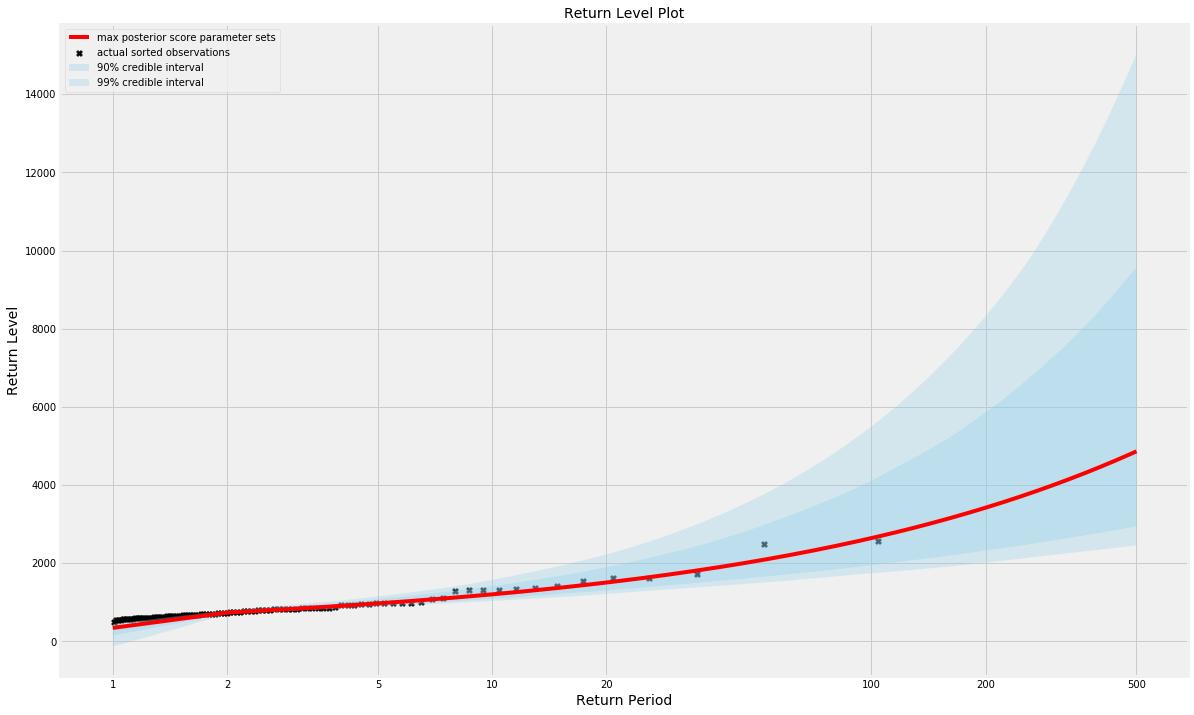

In [21]:
plt.figure(figsize=(18, 12))
plt.plot(np.log10(RP), RL_max, color='r', label='max posterior score parameter sets')
plt.scatter(np.log10([(len(data_meas)+1)/(len(data_meas)+1-k) for k in np.arange(1, len(data_meas)+1, 1)]), np.sort(data_meas), label='actual sorted observations', color='black', marker='X')
plt.fill_between(x=np.log10(RP), y1=percentile_95, y2=percentile_5, alpha=0.3, label='90% credible interval', facecolor='skyblue')
plt.fill_between(x=np.log10(RP), y1=percentile_995, y2=percentile_05, alpha=0.27, label='99% credible interval', facecolor='skyblue')
plt.legend(loc='upper left')
plt.xticks(np.log10([1,2,5,10,20,100,200,500]), [1,2,5,10,20,100,200,500])
plt.title('Return Level Plot', fontsize=14)
plt.xlabel('Return Period', fontsize=14)
plt.ylabel('Return Level', fontsize=14)
plt.show()

### Prepare the data for Quantile Plot and Plot it:

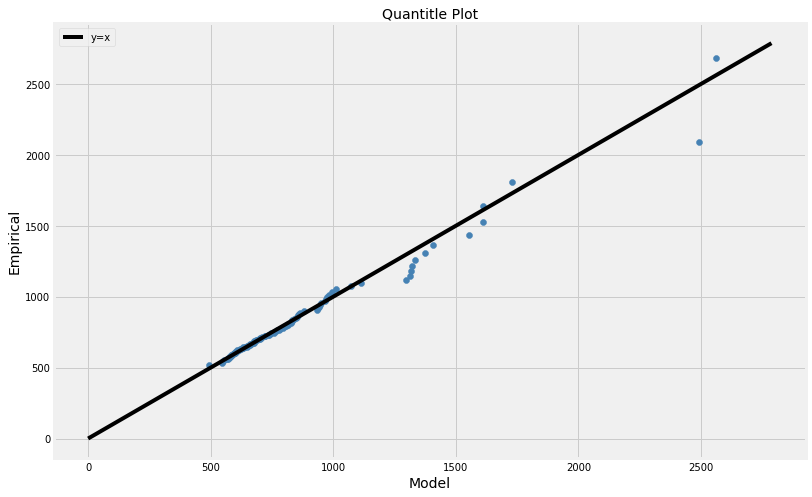

In [22]:
empirical = [stats.genextreme.ppf(q=(i+1)/(len(data_meas)+1), c=max_params[2], loc=max_params[0], scale=max_params[1]) for i in range(len(data_meas))]
plt.figure(figsize=(12, 8))
plt.scatter(np.sort(data_meas), empirical, color='steelblue')
xmin, xmax = plt.xlim()
ymin, ymax = plt.ylim()
axmax = max([xmax, ymax])
plt.plot(np.arange(0, axmax), np.arange(0, axmax), label='y=x', color='black')
plt.title('Quantitle Plot', fontsize=14)
plt.xlabel('Model', fontsize=14)
plt.ylabel('Empirical', fontsize=14)
plt.legend(loc='best')
plt.show()

### Prepare the data for density plot and plot it:

/Users/john/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


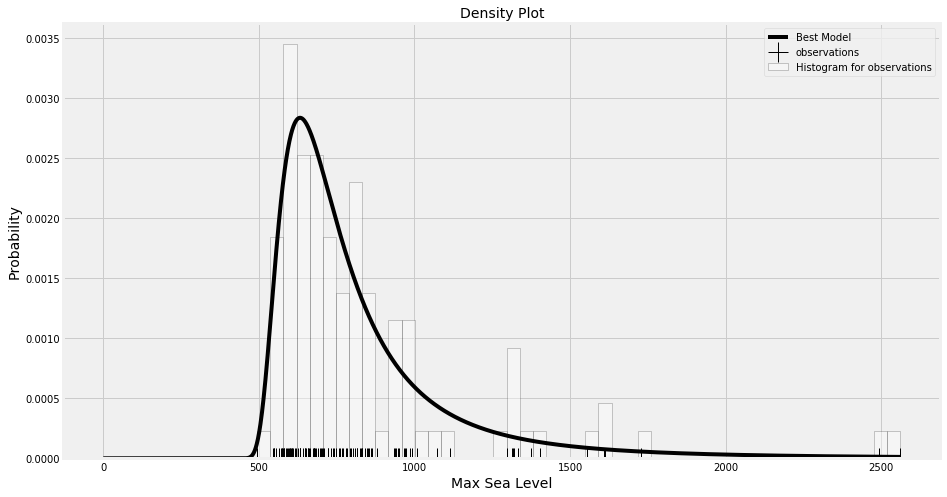

In [23]:
x_range = np.arange(0, max(data_meas)+1, 1)
y_range = [stats.genextreme.pdf(x=xi, c=max_params[2], loc=max_params[0], scale=max_params[1]) for xi in x_range]
plt.figure(figsize=(14,8))
plt.hist(data_meas, bins=np.linspace(min(data_meas), max(data_meas)), normed=True, edgecolor='black', label='Histogram for observations', color='white', alpha=0.4)
plt.plot(x_range, y_range, label='Best Model', color='black')
plt.plot(data_meas, np.zeros_like(data_meas), 'b+', ms=20, color='black', label='observations')
plt.legend()
plt.title('Density Plot', fontsize=14)
plt.xlabel('Max Sea Level', fontsize=14)
plt.ylabel('Probability', fontsize=14)
plt.show()

***